In [1]:
from utils import *
from prepare_ds import *
from train_ml import *
from create_map import *
from validation import *
from visualisation import *
from tqdm import tqdm

downgrade_labels = False
force = False

if downgrade_labels:
    src = DEFAULT_PATH["labels"]
    out = DEFAULT_PATH["labels"] + "downgraded/"
    classes_matching = DEFAULT_PATH["labels"] + "classes_matching.csv"
    downgrade_classes(src, out, classes_matching, force=True)
    DEFAULT_PATH["labels"] = out

# you can use force=True for re-write all caches.
signs = parse_tifs_from(DEFAULT_PATH["images"], "sign", force=force)
signs = signs.query("type == 'sign'")
labels = parse_tifs_from(DEFAULT_PATH["labels"], "label", force=force)
labels = labels.query("type == 'label'")

# Prepare data for generate_dataset.
year = 2020
only_bands = ["r", "b", "g", "n"]
signs_paths = signs.query(
    f"year == {year} and season == '90d' and band in @only_bands"
).sort_values("band")
signs_paths = signs_paths
labels_paths = labels.query(f"year == {year}")

Initialization paths...
All paths was initialized.
Load 'sign' from cached DataFrame to path:  /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_sign.csv
Load 'label' from cached DataFrame to path:  /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_label.csv


Training set of models...: 100%|██████████| 5/5 [00:18<00:00,  3.65s/it]


<Figure size 640x480 with 0 Axes>

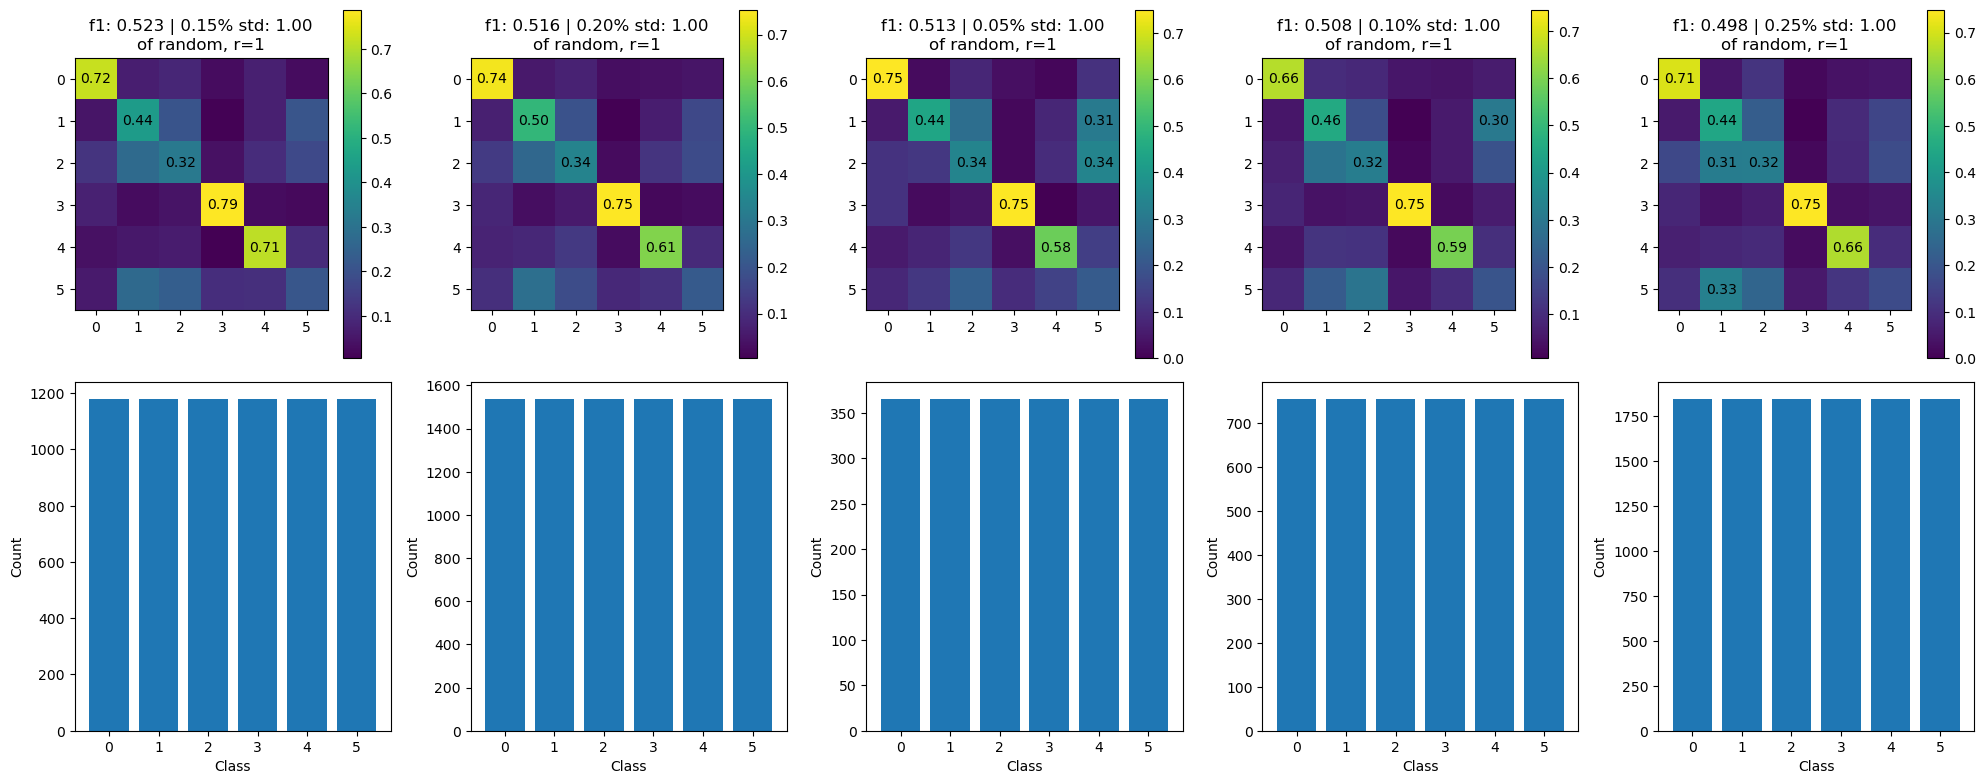

In [9]:
config_grid = {
    "resize": ["by_label"],
    "mask_mode": ["random"],
    # "r": [0.25 * i for i in range(6)[1:]],
    "r": [1],
    # "percent": [0.001, 0.01],
    "percent": [0.05 * i for i in range(6)][1:],
    # "homogen_percent": [0.05 * i for i in range(6)][1:],
    # "homogen_percent": [0.01 * i for i in range(6)][1:],
    # "homogen_percent": [0.3, 0.5],
    "homogen_percent": [1],
    # "stratify": [True, False],
    "stratify": [True],
}
best_models = analyse_best_model(
    config_grid, signs_paths, labels_paths, store_models=True, verbose=False
)

take_first = len(best_models)
models = []
for m in best_models[:take_first]:
    models.append(
        {
            "model": m["model"],
            "report": m["report"],
            "cf_matrix": m["cf_matrix"],
            "f1": m["f1_score"],
        }
    )

spyder_eye(best_models, models)

Load 'tile' from cached DataFrame to path:  /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/path2tif_tile.csv
Reshaping tensor-images...
Start create of map...

map size: x = 10980, y = 10980, bands = 4, total px=120560400


Creating map...: 100%|██████████| 58/58 [06:02<00:00,  6.25s/it]


Map is done.
Data saved to /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/6.0min_/Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/auto_10m_0.591_homogeneous_0.1_0.0.tif
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/6.0min_/Users/stephenhawking/Coding/ML/low2high_map/src/../data/output/auto_10m_0.591_homogeneous_0.1_0.0.tif
Files was loaded.
Etalons will be loaded from cache.
Loading file: /Users/stephenhawking/Coding/ML/low2high_map/src/../data/processing/cropped/etalons/r36000.2020.wc.cor.tif
Files was loaded.


/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/homebrew/anaconda3/envs/Geya/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()

TypeError: Image data of dtype <U173 cannot be converted to float

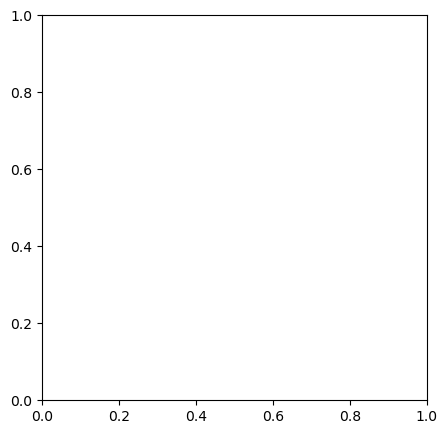

In [3]:
do_create_map = True
if do_create_map:
    # Получаем эталоны
    etalons = DEFAULT_PATH["etalons"]
    map_name = "wc"
    etalons_list = parse_tifs_from(etalons, typeof="etalon", verbose=False)
    etalons_list = etalons_list.query(f"year == {year} and map =='{map_name}'")[
        "path"
    ].to_list()

    # Загружаем тайлы с учетом quality
    quality = True
    if quality:
        tiles = DEFAULT_PATH["images"] + "tiles/"
        tiles = parse_tifs_from(tiles, typeof="tile", verbose=True)
        tiles = tiles.query("band in @only_bands").sort_values("band")["path"]
        tiles = tiles.to_list()
        loaded_tiles = []
        for t in tiles:
            loaded_tiles.append(load_tif(t, only_first=True, verbose=False))
    else:
        _, _, loaded_tiles, _ = generate_dataset(
            signs_paths, labels_paths, percent=0.0001, verbose=False
        )

    # Сортируем модели по f1_score
    sorted_models = sorted(
        zip(best_models, models), key=lambda x: x[0]["f1_score"], reverse=True
    )[:1]

    predicted_res = []
    validation_res = []
    for idx, (bm, model_dict) in enumerate(sorted_models):
        m = model_dict["model"]
        mm = bm["mask_mode"]
        f1 = bm["f1_score"]
        pc = bm["percent"]
        tt = bm["train_time"]
        out = DEFAULT_PATH["output"] + f"auto_10m_{f1:.3f}_{mm}_{pc}_{tt}.tif"
        pred_map = create_map(loaded_tiles, m, out)
        predicted_res.append(pred_map)
        val_result = validate_how_tif(pred_map, etalons_list)
        validation_res.append({"model_idx": idx, "validation": val_result})

    # Визуализация: столбцы по убыванию f1_score
    import matplotlib.pyplot as plt

    fig, axes = plt.subplots(1, len(predicted_res), figsize=(20, 5))
    # Если только одна модель, axes не является списком, а объектом Axes
    if len(predicted_res) == 1:
        axes = [axes]
    for i, pred_map in enumerate(predicted_res):
        # Предполагается, что pred_map - numpy array
        axes[i].imshow(pred_map)
        axes[i].set_title(f"Model {i + 1}\nf1={sorted_models[i][0]['f1_score']:.3f}")
        axes[i].axis("off")
    plt.tight_layout()
    plt.show()
